In [98]:
using Pkg; Pkg.activate(@__DIR__);

  Activating project at `~/Research/Oceananigans-Tutorial-CFP/barotropic_tide`


In [99]:
using Oceananigans,
      Oceananigans.Units
using CUDA

In [107]:
Nx, Nz = 300, 80

architecture = CPU()

H  = 2kilometers
Lx = 1600kilometers

underlying_grid = RectilinearGrid(architecture,
                                  size = (Nx, Nz),
                                  x = (-Lx/2, Lx/2),
                                  z = (-H, 0),
                                  halo = (4, 4), # start with this commented out
                                  topology = (Periodic, Flat, Bounded))

300×1×80 RectilinearGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
├── Periodic x ∈ [-800000.0, 800000.0) regularly spaced with Δx=5333.33
├── Flat y
└── Bounded  z ∈ [-2000.0, 0.0]        regularly spaced with Δz=25.0

In [105]:
underlying_grid

300×1×80 RectilinearGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
├── Periodic x ∈ [-800000.0, 800000.0) regularly spaced with Δx=5333.33
├── Flat y
└── Bounded  z ∈ [-2000.0, 0.0]        regularly spaced with Δz=25.0

Now we want to create a bathymetry as an immersed boundary grid.

$$
h(x) = -H + h_0 \, \exp(-x^2 / 2\sigma^2)
$$

In [117]:
h₀ = 50 # m
width = 5kilometers
bump(x, y) = - H + h₀ * exp(-x^2 / 2width^2)

grid = ImmersedBoundaryGrid(underlying_grid, GridFittedBottom(bump))

300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo:
├── immersed_boundary: GridFittedBottom(min(h)=-2.00e+03, max(h)=-1.96e+03)
├── underlying_grid: 300×1×80 RectilinearGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
├── Periodic x ∈ [-800000.0, 800000.0) regularly spaced with Δx=5333.33
├── Flat y
└── Bounded  z ∈ [-2000.0, 0.0]        regularly spaced with Δz=25.0

In [118]:
c = CenterField(grid)

300×1×80 Field{Center, Center, Center} on ImmersedBoundaryGrid on CPU
├── grid: 300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
├── boundary conditions: FieldBoundaryConditions
│   └── west: Periodic, east: Periodic, south: Nothing, north: Nothing, bottom: ZeroFlux, top: ZeroFlux, immersed: ZeroFlux
└── data: 308×1×88 OffsetArray(::Array{Float64, 3}, -3:304, 1:1, -3:84) with eltype Float64 with indices -3:304×1:1×-3:84
    └── max=0.0, min=0.0, mean=0.0

In [125]:
c₀(x, y, z) = sin(2π/grid.Lx *x) * sin(3 * z * 2π/ grid.Lz)
set!(c, c₀)
c  

300×1×80 Field{Center, Center, Center} on ImmersedBoundaryGrid on CPU
├── grid: 300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
├── boundary conditions: FieldBoundaryConditions
│   └── west: Periodic, east: Periodic, south: Nothing, north: Nothing, bottom: ZeroFlux, top: ZeroFlux, immersed: ZeroFlux
└── data: 308×1×88 OffsetArray(::Array{Float64, 3}, -3:304, 1:1, -3:84) with eltype Float64 with indices -3:304×1:1×-3:84
    └── max=0.999174, min=-0.999174, mean=2.04922e-18

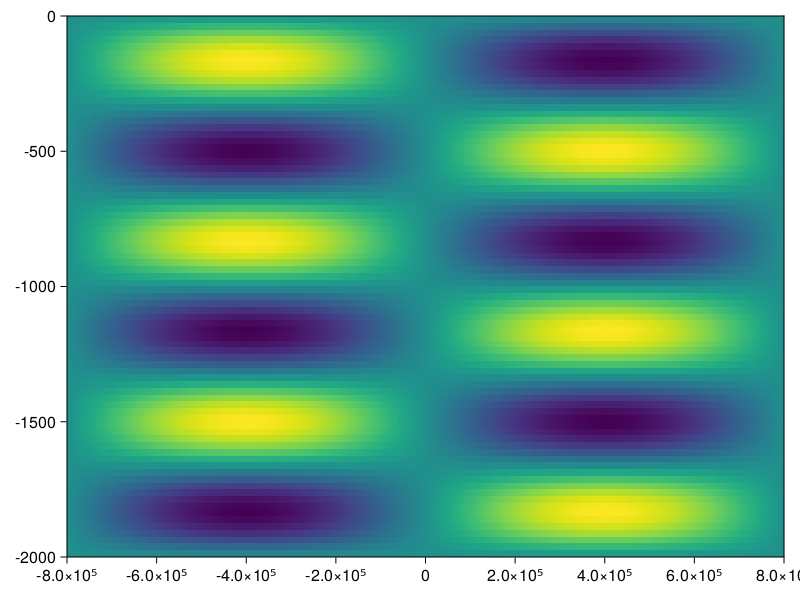

In [126]:
xc, yc, zc = nodes(c)

fig = Figure()
ax = Axis(fig[1, 1])
heatmap!(ax, xc, zc, interior(c, :, 1, :))
fig

In [127]:
∂c∂z = Field(∂z(c))

300×1×81 Field{Center, Center, Face} on ImmersedBoundaryGrid on CPU
├── grid: 300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
├── boundary conditions: FieldBoundaryConditions
│   └── west: Periodic, east: Periodic, south: Nothing, north: Nothing, bottom: Nothing, top: Nothing, immersed: ZeroFlux
├── operand: Derivative at (Center, Center, Face)
├── status: time=0.0
└── data: 308×1×89 OffsetArray(::Array{Float64, 3}, -3:304, 1:1, -3:85) with eltype Float64 with indices -3:304×1:1×-3:85
    └── max=0.0, min=0.0, mean=0.0

In [128]:
compute!(∂c∂z)

300×1×81 Field{Center, Center, Face} on ImmersedBoundaryGrid on CPU
├── grid: 300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
├── boundary conditions: FieldBoundaryConditions
│   └── west: Periodic, east: Periodic, south: Nothing, north: Nothing, bottom: Nothing, top: Nothing, immersed: ZeroFlux
├── operand: Derivative at (Center, Center, Face)
├── status: time=0.0
└── data: 308×1×89 OffsetArray(::Array{Float64, 3}, -3:304, 1:1, -3:85) with eltype Float64 with indices -3:304×1:1×-3:85
    └── max=0.00940248, min=-0.00940248, mean=-1.67641e-20

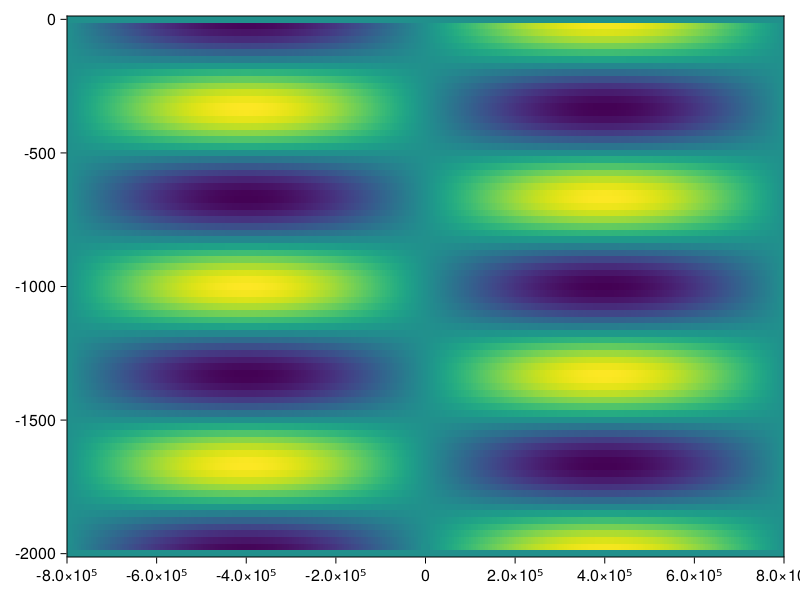

In [129]:
x, y, z = nodes(∂c∂z)

fig = Figure()
ax = Axis(fig[1, 1])
heatmap!(ax, x, z, interior(∂c∂z, :, 1, :))
fig

In [130]:
xC = xnodes(grid, Center())

bottom = CUDA.@allowscalar collect(grid.immersed_boundary.bottom_height[1:Nx, 1]);

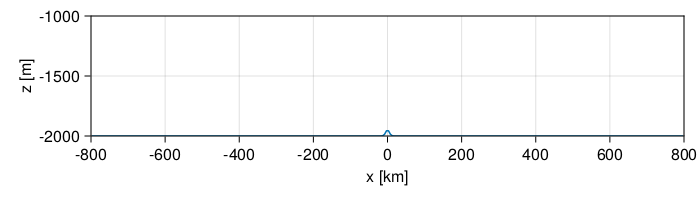

In [131]:
using CairoMakie

fig = Figure(resolution = (700, 200))
ax = Axis(fig[1, 1],
          xlabel="x [km]",
          ylabel="z [m]",
          limits=((-Lx/2e3, Lx/2e3), (-H, -H/2)))

lines!(ax, xC/1e3, bottom)

fig

The $M_2$ tidal forcing. We add forcing in the $u$-momentum equation of the form:

$$
\partial_t u = \dots + f_0 \cos(\omega_2 t)
$$

In [9]:
T₂ = 12.421hours
const ω₂ = 2π / T₂ # radians/sec

0.00014051439111137024

The excursion parameter is a nondimensional number that expresses the ratio of the flow movement due to the tide compared to the size of the width of the hill.

$$
\varepsilon = \frac{U / \omega}{\sigma}
$$

In [132]:
coriolis = FPlane(latitude = -45)

FPlane{Float64}(f=-0.000103126)

In [133]:
coriolis.f

-0.00010312607931384282

In [10]:
ε = 0.2

U_tidal = ε * ω₂ * width

coriolis = FPlane(latitude = -45)

const tidal_forcing_amplitude = U_tidal * (coriolis.f^2 - ω₂^2) / ω₂

@inline tidal_forcing(x, y, z, t) = tidal_forcing_amplitude * cos(ω₂ * t)

tidal_forcing (generic function with 1 method)

In [134]:
tidal_timescale = 1 / ω₂

Δt = 0.02 * tidal_timescale

@show prettytime(Δt)

prettytime(Δt) = "2.372 minutes"


"2.372 minutes"

In [137]:
prettytime(100000)

"1.157 days"

In [41]:
using Oceananigans.Models.HydrostaticFreeSurfaceModels: FFTImplicitFreeSurfaceSolver

fft_preconditioner = FFTImplicitFreeSurfaceSolver(grid)
free_surface = ImplicitFreeSurface(solver_method=:PreconditionedConjugateGradient, preconditioner=fft_preconditioner);

In [138]:
?HydrostaticFreeSurfaceModel

search: HydrostaticFreeSurfaceModel



```
HydrostaticFreeSurfaceModel(; grid,
                                         clock = Clock{eltype(grid)}(0, 0, 1),
                            momentum_advection = CenteredSecondOrder(),
                              tracer_advection = CenteredSecondOrder(),
                                      buoyancy = SeawaterBuoyancy(eltype(grid)),
                                      coriolis = nothing,
                                  free_surface = ImplicitFreeSurface(gravitational_acceleration=g_Earth),
                           forcing::NamedTuple = NamedTuple(),
                                       closure = nothing,
               boundary_conditions::NamedTuple = NamedTuple(),
                                       tracers = (:T, :S),
                 particles::ParticlesOrNothing = nothing,
         biogeochemistry::AbstractBGCOrNothing = nothing,
                                    velocities = nothing,
                                      pressure = nothing,
                            diffusivity_fields = nothing,
                              auxiliary_fields = NamedTuple(),
        calculate_only_active_cells_tendencies = false
)
```

Construct a hydrostatic model with a free surface on `grid`.

# Keyword arguments

  * `grid`: (required) The resolution and discrete geometry on which `model` is solved. The architecture (CPU/GPU) that the model is solve is inferred from the architecture of the grid.
  * `momentum_advection`: The scheme that advects velocities. See `Oceananigans.Advection`.
  * `tracer_advection`: The scheme that advects tracers. See `Oceananigans.Advection`.
  * `buoyancy`: The buoyancy model. See `Oceananigans.BuoyancyModels`.
  * `coriolis`: Parameters for the background rotation rate of the model.
  * `forcing`: `NamedTuple` of user-defined forcing functions that contribute to solution tendencies.
  * `free_surface`: The free surface model.
  * `closure`: The turbulence closure for `model`. See `Oceananigans.TurbulenceClosures`.
  * `boundary_conditions`: `NamedTuple` containing field boundary conditions.
  * `tracers`: A tuple of symbols defining the names of the modeled tracers, or a `NamedTuple` of            preallocated `CenterField`s.
  * `particles`: Lagrangian particles to be advected with the flow. Default: `nothing`.
  * `biogeochemistry`: Biogeochemical model for `tracers`.
  * `velocities`: The model velocities. Default: `nothing`.
  * `pressure`: Hydrostatic pressure field. Default: `nothing`.
  * `diffusivity_fields`: Diffusivity fields. Default: `nothing`.
  * `auxiliary_fields`: `NamedTuple` of auxiliary fields. Default: `nothing`


In [141]:
model = HydrostaticFreeSurfaceModel(grid = grid,
                                    free_surface = free_surface,
                                    coriolis = coriolis,
                                    buoyancy = BuoyancyTracer(),
                                    tracers = :b,
                                    momentum_advection = WENO(),
                                    tracer_advection = WENO(),
                                    # closure = HorizontalScalarDiffusivity(ν=1e2, κ=1e2),
                                    forcing = (u = tidal_forcing,))

HydrostaticFreeSurfaceModel{CPU, ImmersedBoundaryGrid}(time = 0 seconds, iteration = 0)
├── grid: 300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
├── timestepper: QuasiAdamsBashforth2TimeStepper
├── tracers: b
├── closure: Nothing
├── buoyancy: BuoyancyTracer with ĝ = NegativeZDirection()
├── free surface: ImplicitFreeSurface with gravitational acceleration 9.80665 m s⁻²
│   └── solver: PCGImplicitFreeSurfaceSolver
└── coriolis: FPlane{Float64}

In [145]:
model.architecture

CPU()

In [146]:
stop_time = 12T₂

simulation = Simulation(model, Δt=Δt, stop_time=stop_time)

Simulation of HydrostaticFreeSurfaceModel{CPU, ImmersedBoundaryGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 2.372 minutes
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 6.210 days
├── Stop iteration : Inf
├── Wall time limit: Inf
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [147]:
using Printf

wall_clock = Ref(time_ns())

function print_progress(sim)

    elapsed = 1e-9 * (time_ns() - wall_clock[])

    msg = @sprintf("iteration: %d, time: %s, wall time: %s, max|w|: %6.3e, m s⁻¹, next Δt: %s\n",
                   iteration(sim), prettytime(sim), prettytime(elapsed),
                   maximum(abs, sim.model.velocities.w), prettytime(sim.Δt))

    wall_clock[] = time_ns()

    @info msg

    return nothing
end

simulation.callbacks[:print_progress] = Callback(print_progress, IterationInterval(200))

Callback of print_progress on IterationInterval(200)

## Diagnostics

There are no predefine diagnostics in Oceananigans! Instead users are expected to construct their own using normal algebraic operations and calculus!

Each model has velocities and some tracers, like buoyancy $b$ or temperature and salinity ($T$ and $S$).

Let's create a few!

In [148]:
b = model.tracers.b
u, v, w = model.velocities

NamedTuple with 3 Fields on 300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo:
├── u: 300×1×80 Field{Face, Center, Center} on ImmersedBoundaryGrid on CPU
├── v: 300×1×80 Field{Center, Face, Center} on ImmersedBoundaryGrid on CPU
└── w: 300×1×81 Field{Center, Center, Face} on ImmersedBoundaryGrid on CPU

In [149]:
U = Field(Average(u))

u′ = u - U

BinaryOperation at (Face, Center, Center)
├── grid: 300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
└── tree: 
    - at (Face, Center, Center)
    ├── 300×1×80 Field{Face, Center, Center} on ImmersedBoundaryGrid on CPU
    └── 1×1×1 Field{Nothing, Nothing, Nothing} reduced over dims = (1, 2, 3) on ImmersedBoundaryGrid on CPU

The buoyancy frequency $N^2 = \partial_z b$:

In [150]:
N² = ∂z(b)

Derivative at (Center, Center, Face)
├── grid: 300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
└── tree: 
    ∂zᶜᶜᶠ at (Center, Center, Face) via identity
    └── 300×1×80 Field{Center, Center, Center} on ImmersedBoundaryGrid on CPU

The velocity vertical shear squared, $S^2 = (\partial_z u)^2 + (\partial_z v)^2$:

In [151]:
S² = @at (Center, Center, Face) ∂z(u)^2 + ∂z(v)^2

BinaryOperation at (Center, Center, Face)
├── grid: 300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
└── tree: 
    + at (Center, Center, Face)
    ├── ^ at (Center, Center, Face)
    │   ├── ∂zᶠᶜᶠ at (Center, Center, Face) via ℑxᶜᵃᵃ
    │   │   └── 300×1×80 Field{Face, Center, Center} on ImmersedBoundaryGrid on CPU
    │   └── 2
    └── ^ at (Center, Center, Face)
        ├── ∂zᶜᶠᶠ at (Center, Center, Face) via ℑyᵃᶜᵃ
        │   └── 300×1×80 Field{Center, Face, Center} on ImmersedBoundaryGrid on CPU
        └── 2

And the Richardson number, $Ri = N^2 / S^2$.

In [152]:
Ri = N² / S²

BinaryOperation at (Center, Center, Face)
├── grid: 300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
└── tree: 
    / at (Center, Center, Face)
    ├── ∂zᶜᶜᶠ at (Center, Center, Face) via identity
    │   └── 300×1×80 Field{Center, Center, Center} on ImmersedBoundaryGrid on CPU
    └── + at (Center, Center, Face)
        ├── ^ at (Center, Center, Face)
        │   ├── ∂zᶠᶜᶠ at (Center, Center, Face) via ℑxᶜᵃᵃ
        │   │   └── 300×1×80 Field{Face, Center, Center} on ImmersedBoundaryGrid on CPU
        │   └── 2
        └── ^ at (Center, Center, Face)
            ├── ∂zᶜᶠᶠ at (Center, Center, Face) via ℑyᵃᶜᵃ
            │   └── 300×1×80 Field{Center, Face, Center} on ImmersedBoundaryGrid on CPU
            └── 2

In [153]:
name = "barotropic_tide"

simulation.output_writers[:fields] = JLD2OutputWriter(model, (; Ri, N², u′, u, w, b),
                                                      schedule = TimeInterval(15minutes),
                                                      with_halos = false,
                                                      filename = name,
                                                      overwrite_existing = true)

JLD2OutputWriter scheduled on TimeInterval(15 minutes):
├── filepath: ./barotropic_tide.jld2
├── 6 outputs: (Ri, N², u′, u, w, b)
├── array type: Array{Float64}
├── including: [:grid, :coriolis, :buoyancy, :closure]
└── max filesize: Inf YiB

## Initial conditions

In [154]:
# Initial conditions
uᵢ(x, y, z) = U_tidal

Nᵢ² = 4e-5  # [s⁻²] initial buoyancy frequency / stratification
bᵢ(x, y, z) = Nᵢ² * z

set!(model, u=uᵢ, b=bᵢ)

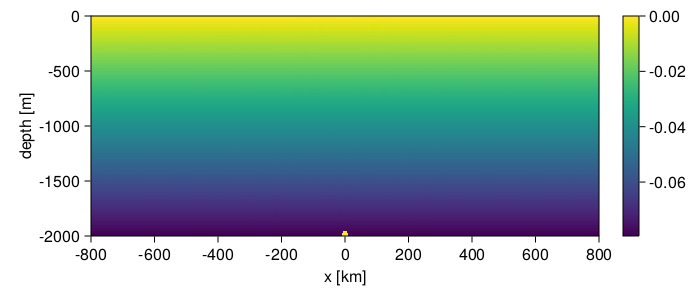

In [63]:
fig = Figure(resolution = (700, 300))

ax = Axis(fig[1, 1],
          xlabel = "x [km]",
          ylabel = "depth [m]")

x, y, z = nodes(b)

hm = heatmap!(ax, x/1e3, z, collect(interior(b, :, 1, :)))
Colorbar(fig[1, 2], hm)

fig

In [155]:
run!(simulation)

[ Info: Initializing simulation...
[ Info: iteration: 0, time: 0 seconds, wall time: 2.194 minutes, max|w|: 6.587e-04, m s⁻¹, next Δt: 2.372 minutes
[ Info:     ... simulation initialization complete (8.487 seconds)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (125.700 ms).
[ Info: iteration: 200, time: 7.158 hours, wall time: 24.401 seconds, max|w|: 2.608e-04, m s⁻¹, next Δt: 2.372 minutes
[ Info: iteration: 400, time: 14.290 hours, wall time: 17.012 seconds, max|w|: 7.229e-04, m s⁻¹, next Δt: 2.372 minutes
[ Info: iteration: 600, time: 21.448 hours, wall time: 16.885 seconds, max|w|: 1.069e-03, m s⁻¹, next Δt: 2.372 minutes
[ Info: iteration: 800, time: 1.191 days, wall time: 17.433 seconds, max|w|: 1.120e-03, m s⁻¹, next Δt: 2.372 minutes
[ Info: iteration: 1000, time: 1.489 days, wall time: 17.329 seconds, max|w|: 8.573e-04, m s⁻¹, next Δt: 2.372 minutes
[ Info: iteration: 1200, time: 1.786 days, wall time: 17.207 seconds, max|w|: 6.164e-04, m s

## Reading output + visualise

Now we can load the output and visualise.

In [156]:
saved_output_filename = name * ".jld2"

u_t  = FieldTimeSeries(saved_output_filename, "u")
u′_t = FieldTimeSeries(saved_output_filename, "u′")
w_t  = FieldTimeSeries(saved_output_filename, "w")
N²_t = FieldTimeSeries(saved_output_filename, "N²")

times = u_t.times

597-element Vector{Float64}:
      0.0
    900.0
   1800.0
   2700.0
   3600.0
   4500.0
   5400.0
   6300.0
   7200.0
   8100.0
   9000.0
   9900.0
  10800.0
      ⋮
 526500.0
 527400.0
 528300.0
 529200.0
 530100.0
 531000.0
 531900.0
 532800.0
 533700.0
 534600.0
 535500.0
 536400.0

Fields live on different parts of the grid. The information is stored within each field so Oceananigans.jl gives us functionality to get the grid points where each field lives -- we don't need to do it by hand.

In [157]:
xu,  yu,  zu  = nodes(u_t[1])
xw,  yw,  zw  = nodes(w_t[1])
xN², yN², zN² = nodes(N²_t[1])

([-797333.3333333334, -792000.0, -786666.6666666666, -781333.3333333334, -776000.0, -770666.6666666666, -765333.3333333334, -760000.0, -754666.6666666666, -749333.3333333334  …  749333.3333333334, 754666.6666666666, 760000.0, 765333.3333333334, 770666.6666666666, 776000.0, 781333.3333333334, 786666.6666666666, 792000.0, 797333.3333333334], StepRangeLen(1.0, 0.0, 1), [-2000.0, -1975.0, -1950.0, -1925.0, -1900.0, -1875.0, -1850.0, -1825.0, -1800.0, -1775.0  …  -225.0, -200.0, -175.0, -150.0, -125.0, -100.0, -75.0, -50.0, -25.0, 0.0])

In [158]:
using Oceananigans.ImmersedBoundaries: mask_immersed_field!

function mask_and_get_interior(φ_t, n)
    mask_immersed_field!(φ_t[n], NaN)
    return interior(φ_t[n], :, 1, :)
end

mask_and_get_interior (generic function with 1 method)

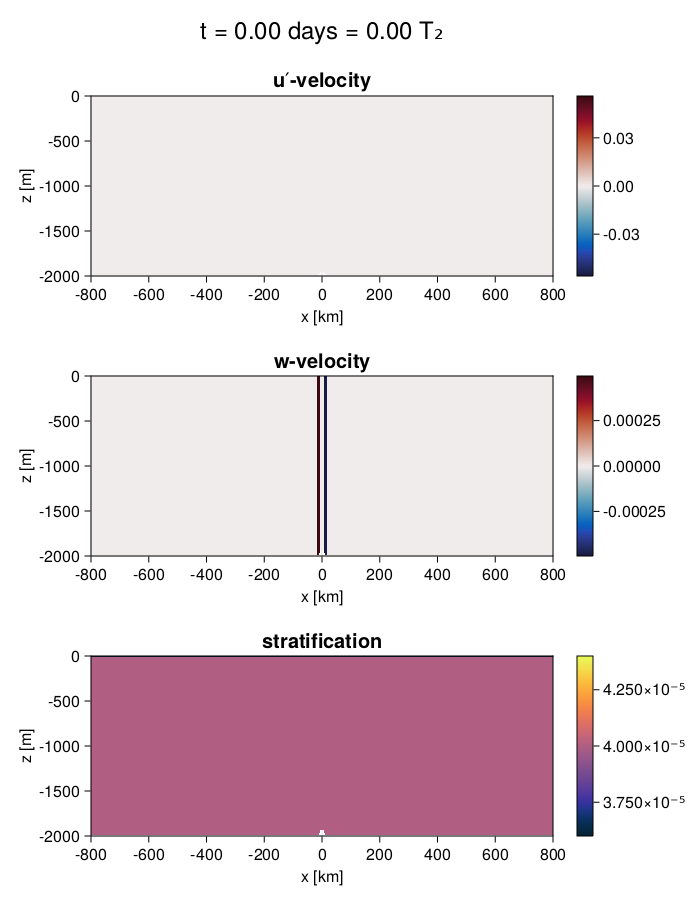

In [159]:
n = Observable(1)

title = @lift @sprintf("t = %1.2f days = %1.2f T₂", round(times[$n]/day, digits=2) , round(times[$n]/T₂, digits=2))

u′ₙ = @lift mask_and_get_interior(u′_t, $n)
wₙ  = @lift mask_and_get_interior(w_t, $n)
N²ₙ = @lift mask_and_get_interior(N²_t, $n)

axis_kwargs = (xlabel = "x [km]",
               ylabel = "z [m]",
               limits = ((-Lx/2e3, Lx/2e3), (-H, 0)),
               titlesize = 20)

ulim   = 0.5 * maximum(abs, u_t[end])
wlim   = maximum(abs, w_t[end])

fig = Figure(resolution = (700, 900))

ax_u = Axis(fig[2, 1];
            title = "u′-velocity", axis_kwargs...)

ax_w = Axis(fig[3, 1];
            title = "w-velocity", axis_kwargs...)

ax_N² = Axis(fig[4, 1];
             title = "stratification", axis_kwargs...)

fig[1, :] = Label(fig, title, fontsize=24, tellwidth=false)

hm_u = heatmap!(ax_u, xu/1e3, zu, u′ₙ;
                colorrange = (-ulim, ulim),
                colormap = :balance)
Colorbar(fig[2, 2], hm_u)

hm_w = heatmap!(ax_w, xw/1e3, zw, wₙ;
                colorrange = (-wlim, wlim),
                colormap = :balance)
Colorbar(fig[3, 2], hm_w)

hm_N² = heatmap!(ax_N², xN²/1e3, zN², N²ₙ;
                 colorrange = (0.9Nᵢ², 1.1Nᵢ²),
                 colormap = :thermal)
Colorbar(fig[4, 2], hm_N²)

fig

In [160]:
@info "Making an animation from saved data..."

frames = 1:length(times)

CairoMakie.record(fig, name * ".mp4", frames, framerate=24) do i
    msg = string("Plotting frame ", i, " of ", frames[end])
    print(msg * " \r")
    n[] = i
end

[ Info: Making an animation from saved data...


"barotropic_tide.mp4"

![](barotropic_tide.mp4)